In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import scipy.stats

import tqdm.notebook

rng=np.random.default_rng()
import matplotlib.pyplot as plt
%matplotlib inline

import reproduciblesignrates

# 1. Overview

This package is designed to analyze data from the following setting.

- We are interested in real-valued parameters $\theta_1,\theta_2 ... \theta_n$.  For example, $\theta_i$ might indicate the effect of a particular drug on a particular gene.
- We have designed an experimental procedure which can estimate these parameters.
- We have two performed the experiment twice.

Given data of this form, we assume the user can calculate three quantities of interest for each parameter $\theta_i$.  

1. Use the first replicate ("the training replicate") to produce a $p$-value, denoted $\rho_i$, for null hypothesis that $\theta_i=0$.
1. Use the training experiment to produce an object $\hat Y_i$ estimating the sign of $\theta_i$ (i.e., if the estimator is accurate, $\hat Y_i=1$ if $\theta_i>0$ and $\hat Y_i=-1$ if $\theta_i<0$).
1. Use the second replicate ("the validation replicate") produce an independent estimate $Y_i$ estimating the sign of $\theta_i$.

This package uses $\rho,\hat Y,Y$ to visualize whether the two replicates yielded the same results.  It does so using a quantity called the **Reproducible Sign Proportion**, defined as 

$$\mathrm{RSP}(Y;\hat Y,\rho,\alpha) \triangleq \frac{\#\{i:\ \hat Y_i = Y_i,\ \rho_i\leq \alpha\}}{\#\{i:\ \rho_i\leq \alpha\}}$$

In some cases each experimental procedure includes many subexperiments, and each subexperiment is approximately independent.  With subexperiments, this package can be used to also estimate confidence interval for the **Reproducible Sign Rate**, defined as $\mathrm{RSR}(\hat Y,\rho,\alpha)\triangleq \mathbb{E}_Y[\mathrm{RSP}(Y;\hat Y,\rho,\alpha)]$.  

The rest of this notebook will go through a toy example.

# 2. Create simulated data (we'll use this to show how to use this package)

We simulate a single-cell mRNA experiment with the following procedure.  
1. Collect a large population of cells.
2. Divide the cells into 100 groups.
3. Divide each group into two subgroups: a treatment and a control group.  Apply a treatment to the each treatment subgroup.
4. Measure gene expression for all cells.

This experiment is designed to estimate parameters of the form

$$\theta_{tg} = \mbox{the log-fold-change in the mean expression of gene $g$ when exposed to treatment $t$?}$$

We will assume that the procedure for each treatment is an independent subexperiment.  Having multiple independent subexperiments will enable us to obtain confidence intervals for the RSR.

### Create "ground truth" for how the treatments affect the cells.


In [63]:
n_treatments=100
n_genes=300
control_means=rng.exponential(size=(n_genes)) # mean expression of unperturbed cells

# most treatments do nothing to most genes
# but a few have a large effect
treatment_lfcs=np.where(
    rng.uniform(size=(n_treatments,n_genes))<.01,
    rng.normal(size=(n_treatments,n_genes)),
    0
)
treatment_means=control_means*np.exp(treatment_lfcs)

### Create a function that runs the simulated experiment

In [64]:
def perform_experiment(n_cells_per_group):
    treatment_measurements=[]
    control_measurements=[]
    for i in range(n_treatments):
        control_measurements.append(rng.poisson(control_means,size=(n_cells_per_group,n_genes)))
        treatment_measurements.append(rng.poisson(treatment_means[i],size=(n_cells_per_group,n_genes)))
    
    return control_measurements,treatment_measurements

### Create two replicates of the data

In [65]:
rep1_control_measurements,rep1_treatment_measurements = perform_experiment(25)
rep2_control_measurements,rep2_treatment_measurements = perform_experiment(25)

### Perform hypothesis tests on the measurements.

For each parameter $\theta_{tg}$, we compute
- a $p$-value testing the null hypothesis that $\theta_{tg}=0$ and 
- an estimate for $\mathrm{sign}(\theta_{tg})$.

In [66]:
def analyze_experiment(control_measurements,treatment_measurements,eps=1e-9):
    p_values=np.zeros((n_treatments,n_genes)) # p_values[t,g] gives p-value for gene g and treatment t
    sign_estimates=np.zeros((n_treatments,n_genes),dtype=int) # sign_estimates[t,g] estimates sign(theta_tg) for gene g and treatment t
    
    for t in tqdm.notebook.trange(n_treatments):
        X=control_measurements[t]
        Y=treatment_measurements[t]

        # when X,Y are both Poisson, mann whitney gives a valid
        # test for the null hypothesis that E[X]=E[Y]
        p_values[t]=sp.stats.mannwhitneyu(X,Y).pvalue  

        # estimate sign(log(E[X]/E[Y])) (with epsilon added to handle cases with all zeros)
        sign_estimates[t] = np.sign(np.log(np.mean(Y,axis=0)+eps)-np.log(np.mean(X,axis=0)+eps)).astype(int)
                
    return p_values,sign_estimates

In [67]:
rep1_p_values,rep1_sign_estimates=analyze_experiment(rep1_control_measurements,rep1_treatment_measurements)
rep2_p_values,rep2_sign_estimates=analyze_experiment(rep2_control_measurements,rep2_treatment_measurements)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# 3. Plot reproducibility between replicates to estimate the the RSR

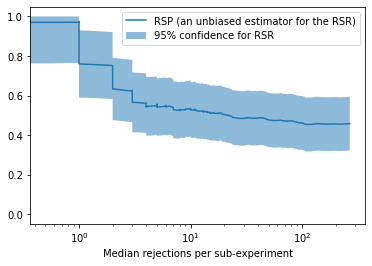

In [84]:
info=reproduciblesignrates.process_from_matrices(np.log(rep1_p_values),rep1_sign_estimates,rep2_sign_estimates)
plt.plot(info.median_rejections,info.RSP,label='RSP (an unbiased estimator for the RSR)')
plt.fill_between(info.median_rejections,*info.confidence_interval(.05),alpha=.5,label='95% confidence for RSR')

plt.gca().set_xscale('log')
plt.xlabel("Median rejections per sub-experiment")
plt.legend()

# 4. Note that $(2-2\cdot \mathrm{RSR})$ controls Type S error

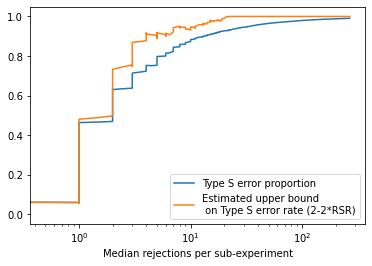

In [94]:
gt_info=reproduciblesignrates.process_from_matrices(np.log(rep1_p_values),rep1_sign_estimates,np.sign(treatment_lfcs).astype(int))
plt.plot(info.median_rejections,1-gt_info.RSP,label="Type S error proportion")
plt.plot(info.median_rejections,np.clip(2-2*info.RSP,0,1),label="Estimated upper bound\n on Type S error rate (2-2*RSR)")

plt.gca().set_xscale('log')
plt.xlabel("Median rejections per sub-experiment")
plt.legend()